## Projekt SAD - ćwiczenia
#### Autorzy: Julita Będkowska, Tomasz Gogolewski - grupa 8

Import niezbędnych bibliotek

In [28]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
np.set_printoptions(suppress=True)

# Opis problemu
#### Naszymi danymi do analizy jest lista stu najczęściej odtwarzanych utowrów w serwisie Spotify w 2018 roku. Wybraliśmy ten temat ponieważ oboje interesujemy się muzyką. Dane wydają się bardzo ciekawe, dzięki nim można się dowiedzieć, jakich utworów najęchtniej słuchają ludzie. Być może też przewidzeić, jakie utwory będą popularne w tym roku. 
#### Wcześniej próbowaliśmy dokonać analizy zupełnie innych, równie ciekawych tematów. Niestety miały one po kilkaset tysięcy rekordów, co bardzo wydłużało analizę. Był to kolejny powód wyboru top 100 Spotify. 
#### Spotify publikuje taką listę pod koniec każdego roku. W danych znajdziemy: 
 - Spotify URI dla utworu
 - Tytuł piosenki
 - Wykonawca utworu
 - Funkcje audio dla utworu (takie jak taneczność, tempo, klucz itp.)

#### Bardziej szczegółowe wyjaśnienie funkcji audio można znaleźć w zakładce Metadane na poniżej podanej stronie ze źródłem.
#### Źródło danych - https://www.kaggle.com/nadintamer/top-spotify-tracks-of-2018

# Wstępna analiza danych

Wczytanie danych

In [29]:
data = pd.read_csv('top2018.csv')

# Wstępna analiza danych

Wyświetlenie pierwszych wierszy:

In [30]:
data.head()

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,6DCZcSspjsKoFjzjrWoCd,God's Plan,Drake,0.754,0.449,7.0,-9.211,1.0,0.1090,0.0332,0.000083,0.552,0.357,77.169,198973.0,4.0
1,3ee8Jmje8o58CHK66QrVC,SAD!,XXXTENTACION,0.740,0.613,8.0,-4.880,1.0,0.1450,0.2580,0.003720,0.123,0.473,75.023,166606.0,4.0
2,0e7ipj03S05BNilyu5bRz,rockstar (feat. 21 Savage),Post Malone,0.587,0.535,5.0,-6.090,0.0,0.0898,0.1170,0.000066,0.131,0.140,159.847,218147.0,4.0
3,3swc6WTsr7rl9DqQKQA55,Psycho (feat. Ty Dolla $ign),Post Malone,0.739,0.559,8.0,-8.011,1.0,0.1170,0.5800,0.000000,0.112,0.439,140.124,221440.0,4.0
4,2G7V7zsVDxg1yRsu7Ew9R,In My Feelings,Drake,0.835,0.626,1.0,-5.833,1.0,0.1250,0.0589,0.000060,0.396,0.350,91.030,217925.0,4.0


Usunięcie kolumn, które zawierają tekst i nie będą analizowane (spotify URI, tytuł oraz artysta)

In [31]:
data = data.drop(columns=['id','name','artists'])

Histogramy dla pozostałych danych:

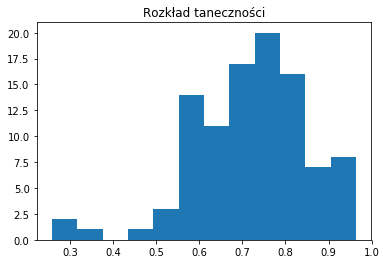

In [32]:
data['danceability'].hist(bins=12)
plt.title('Rozkład taneczności')
plt.grid(None)
plt.show()

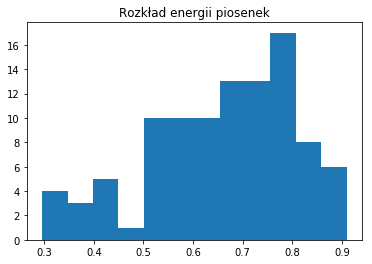

In [33]:
data['energy'].hist(bins=12)
plt.title('Rozkład energii piosenek')
plt.grid(None)
plt.show()

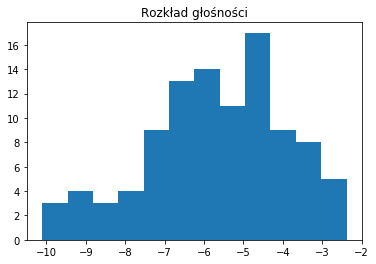

In [34]:
data['loudness'].hist(bins=12)
plt.title('Rozkład głośności')
plt.grid(None)
plt.show()

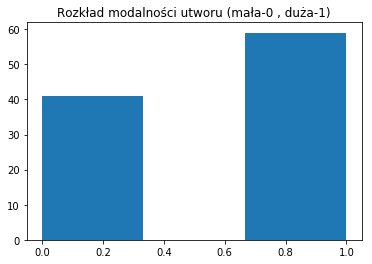

In [35]:
data['mode'].hist(bins=3)
plt.title('Rozkład modalności utworu (mała-0 , duża-1)')
plt.grid(None)
plt.show()

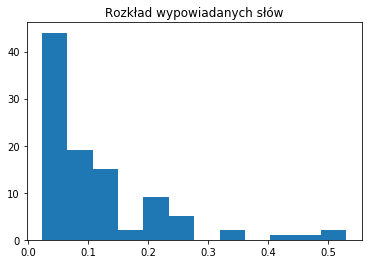

In [36]:
data['speechiness'].hist(bins=12)
plt.title('Rozkład wypowiadanych słów')
plt.grid(None)
plt.show()

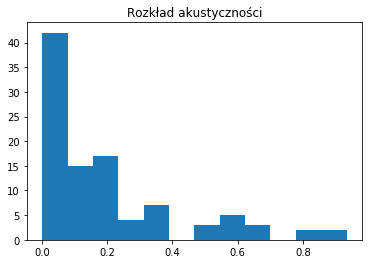

In [37]:
data['acousticness'].hist(bins=12)
plt.title('Rozkład akustyczności')
plt.grid(None)
plt.show()

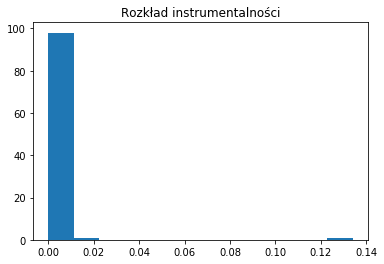

In [38]:
data['instrumentalness'].hist(bins=12)
plt.title('Rozkład instrumentalności')
plt.grid(None)
plt.show()

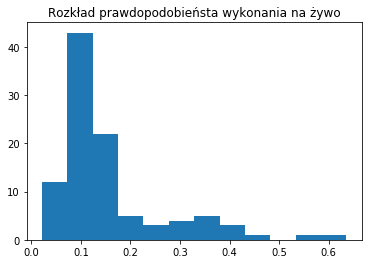

In [39]:
data['liveness'].hist(bins=12)
plt.title('Rozkład prawdopodobieństa wykonania na żywo')
plt.grid(None)
plt.show()

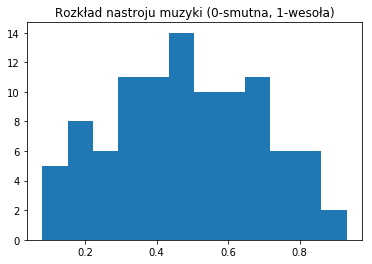

In [40]:
data['valence'].hist(bins=12)
plt.title('Rozkład nastroju muzyki (0-smutna, 1-wesoła)')
plt.grid(None)
plt.show()

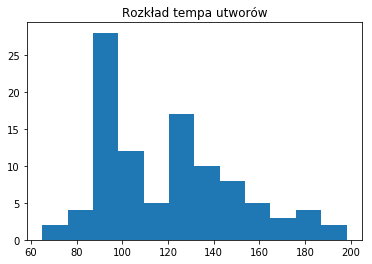

In [41]:
data['tempo'].hist(bins=12)
plt.title('Rozkład tempa utworów')
plt.grid(None)
plt.show()

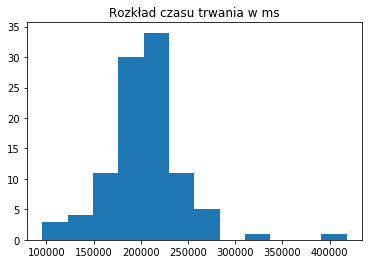

In [42]:
data['duration_ms'].hist(bins=12)
plt.title('Rozkład czasu trwania w ms')
plt.grid(None)
plt.show()

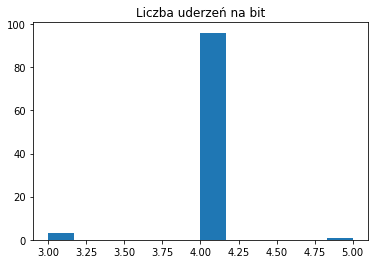

In [43]:
data['time_signature'].hist(bins=12)
plt.title('Liczba uderzeń na bit')
plt.grid(None)
plt.show()

Usuwamy kolumny, w ktorych dane skupiają się wokół jednej wartości. Mniejsza liczba kolumn ułatwi analize, a skoro wartości dla każdego rekordu są podobne lub takie same nie wniosą wiele do analizy. 

In [44]:
data = data.drop(columns=['instrumentalness','time_signature','liveness'])

Podstawowe statystyki opisowe:

In [45]:
data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,valence,tempo,duration_ms
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.71646,0.659060,5.330000,-5.677640,0.590000,0.115569,0.195701,0.484443,119.904180,205206.780000
std,0.13107,0.145067,3.676447,1.777577,0.494311,0.104527,0.220946,0.206145,28.795984,40007.893404
min,0.25800,0.296000,0.000000,-10.109000,0.000000,0.023200,0.000282,0.079600,64.934000,95467.000000
25%,0.63550,0.562000,1.750000,-6.650500,0.000000,0.045350,0.040225,0.341000,95.730750,184680.000000
50%,0.73300,0.678000,5.000000,-5.566500,1.000000,0.074950,0.109000,0.470500,120.116000,205047.500000
75%,0.79825,0.772250,8.250000,-4.363750,1.000000,0.137000,0.247750,0.641500,140.022750,221493.250000
max,0.96400,0.909000,11.000000,-2.384000,1.000000,0.530000,0.934000,0.931000,198.075000,417920.000000


##### Interpretacja:
#### Zdecydowana większość utworów to piosenki energiczne, taneczne i głośne. Co możemy zobaczyć po średniej trzech pierwszych parametrów. W utworach pada mało słów, większość to muzyka - parametr speechiness.

# Faktyczna analiza

### Standaryzacja danych
Od każdej zmiennej odejmujemy średnią, i dzielimy przez jej odchylenie standardowe

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[data.columns] = scaler.fit_transform(data)

In [63]:
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,valence,tempo,duration_ms
0,0.287854,-1.455314,0.456531,-1.997753,0.833616,-0.063162,-0.739184,-0.621334,-1.491544,-0.156599
1,0.180503,-0.319108,0.729903,0.450984,0.833616,0.282982,0.283383,-0.055789,-1.566444,-0.969690
2,-0.992691,-0.859498,-0.090213,-0.233147,-1.199593,-0.247772,-0.357995,-1.679294,1.394085,0.325071
3,0.172835,-0.693224,0.729903,-1.319276,0.833616,0.013759,1.748092,-0.221552,0.705712,0.407795
4,0.908957,-0.229043,-1.183701,-0.087840,0.833616,0.090680,-0.622280,-0.655462,-1.007767,0.319494


### Klastrowanie metodą k-średnich
Wykonaliśmy pomiary dla 3, 6 oraz 2 klastrów.

In [49]:
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(data)
print(kmeans_3)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [50]:
kmeans_3.labels_

array([2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0,
       1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0, 1, 2, 0, 1, 2, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 1,
       1, 1, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2], dtype=int32)

In [51]:
kmeans_6 = KMeans(n_clusters=6)
kmeans_6.fit(data)
print(kmeans_6)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [52]:
kmeans_6.labels_

array([3, 3, 0, 2, 3, 0, 4, 4, 3, 4, 3, 0, 1, 3, 1, 0, 4, 4, 4, 3, 1, 4,
       1, 0, 4, 1, 0, 0, 5, 0, 3, 4, 0, 0, 1, 2, 0, 4, 2, 0, 5, 1, 0, 0,
       1, 1, 1, 0, 4, 0, 3, 1, 2, 3, 4, 5, 1, 1, 4, 4, 1, 3, 3, 0, 0, 0,
       1, 4, 4, 1, 1, 1, 0, 3, 0, 0, 0, 1, 1, 3, 2, 0, 3, 1, 2, 4, 3, 4,
       4, 3, 4, 5, 2, 0, 2, 0, 0, 0, 0, 2], dtype=int32)

In [53]:
kmeans_2 = KMeans(n_clusters=2)
kmeans_2.fit(data)
print(kmeans_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)


In [54]:
kmeans_2.labels_

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

### Ocena jakości klastrów na podstawie trzech metryk:

#### 1. silhouette

In [55]:
silhouette_3 = metrics.silhouette_score(data, kmeans_3.labels_, metric='euclidean')
silhouette_6 = metrics.silhouette_score(data, kmeans_6.labels_, metric='euclidean')
silhouette_2 = metrics.silhouette_score(data, kmeans_2.labels_, metric='euclidean')

#### 2. wewnątrzgrupowa suma kwadratów

In [56]:
inertia_3 = kmeans_3.inertia_
inertia_6 = kmeans_6.inertia_
inertia_2 = kmeans_2.inertia_

#### 3. Caliński-Harabasz

In [57]:
calinski_harabaz_3 = metrics.calinski_harabaz_score(data, kmeans_3.labels_)
calinski_harabaz_6 = metrics.calinski_harabaz_score(data, kmeans_6.labels_)
calinski_harabaz_2 = metrics.calinski_harabaz_score(data, kmeans_2.labels_)

#### Tabela porównująca wszystkie wartości dla różnej liczby klastrów

In [58]:
pd.DataFrame(np.array([[3, silhouette_3, inertia_3, calinski_harabaz_3], [6, silhouette_6, inertia_6, calinski_harabaz_6], [2, silhouette_2, inertia_2, calinski_harabaz_2]]),
             columns=['liczba klastrów', 'silhouette', 'inertia','calinski_harabaz'])


,liczba klastrów,silhouette,inertia,calinski_harabaz
0,3.0,0.143959,752.295157,15.969377
1,6.0,0.135499,592.992647,12.903597
2,2.0,0.146505,844.990422,17.977646


##### Interpretacja tabeli:
#### Metodami 'silhouette' oraz 'Caliński-Harabasz' najkorzystniejsze wartości otrzymaliśmy dla dwóch klastrów. W przypadku metody  wewnątrzgrupowej sumy kwadratów najkorzystniejszą wartość otrzymaliśmy dla 6 klastrów, jednak korzystne jest też wybranie małej liczby klastrów, dlatego zdecydowaliśmy się na 2. 

### Wykres przedstawiający grupowanie dla 3 wybranych zmiennych

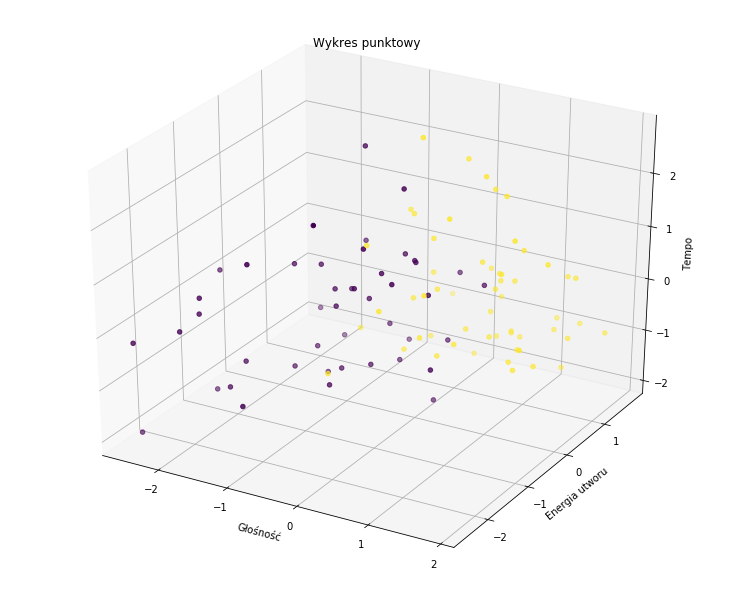

In [69]:
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

ax.scatter(
    data['loudness'],
    data['energy'],
    data['tempo'],
    c=kmeans_2.labels_
)
ax.set_xlabel('Głośność')
ax.set_ylabel('Energia utworu')
ax.set_zlabel('Tempo')
plt.title('Wykres punktowy')
plt.show()

##### centra skupień

In [65]:
kmeans_2.cluster_centers_

array([[-0.1596124 , -0.76065769, -0.0416133 , -0.73088576,  0.38179151,
         0.07337284,  0.32459225, -0.70483333,  0.0144385 , -0.03244465],
       [ 0.13059197,  0.62235629,  0.03404724,  0.59799744, -0.31237487,
        -0.06003233, -0.26557547,  0.57668181, -0.01181332,  0.02654562]])

In [66]:
scaler.inverse_transform(kmeans_2.cluster_centers_)

array([[-0.1596124 , -0.76065769, -0.0416133 , -0.73088576,  0.38179151,
         0.07337284,  0.32459225, -0.70483333,  0.0144385 , -0.03244465],
       [ 0.13059197,  0.62235629,  0.03404724,  0.59799744, -0.31237487,
        -0.06003233, -0.26557547,  0.57668181, -0.01181332,  0.02654562]])

#### Interpretacja:
#### W pierwszej grupie (fioletowe) mamy utwory ciche, z bardzo różną energią. Nstomiast w drugiej grupie (żółte) przeważają utwory głośne, z dużą energią i zróżnicowanym tempem.

## Metoda aglomeracyjna

#### Zostały użyte różne metody łączenia klastrów (kolejno: ‘single’, ‘average’, ‘ward’, ‘median’) oraz dla każdej z nich wyświtlony został dendogram.

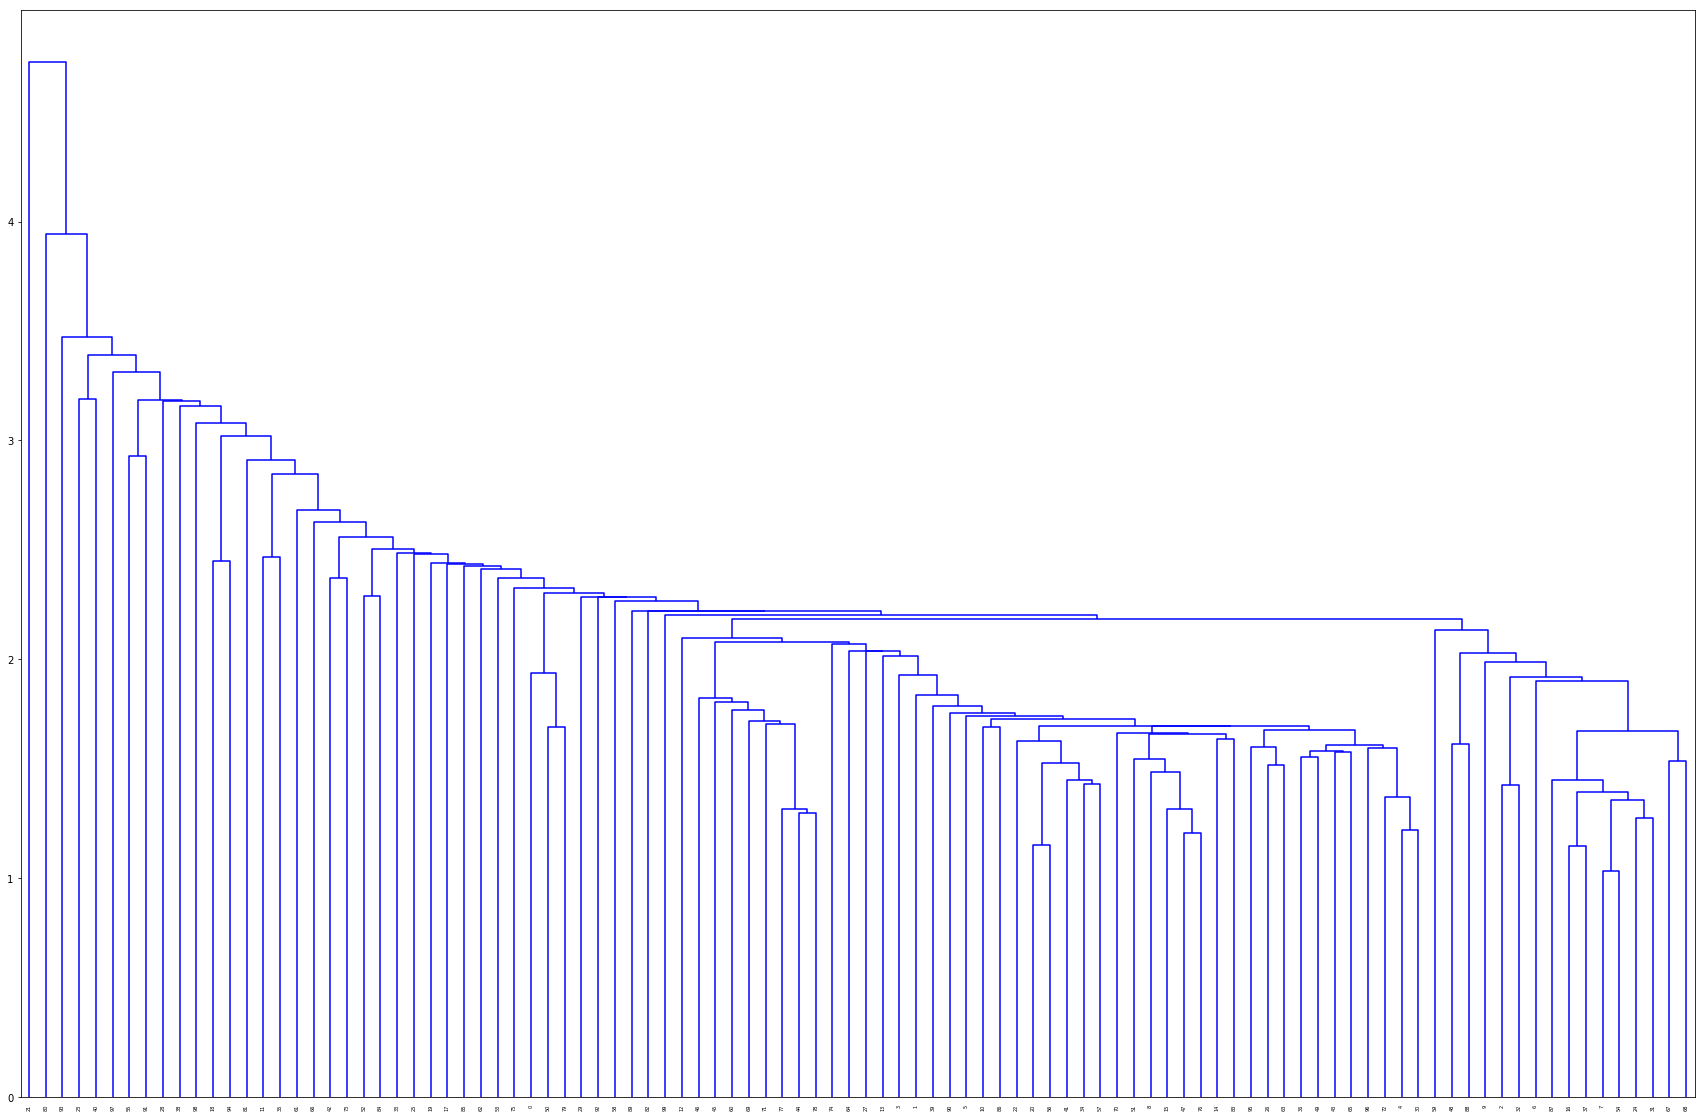

In [48]:
linkage_matrix = linkage(data, 'single')
plt.figure(figsize=(30,20))
dendrogram(linkage_matrix, color_threshold=0)
plt.show()

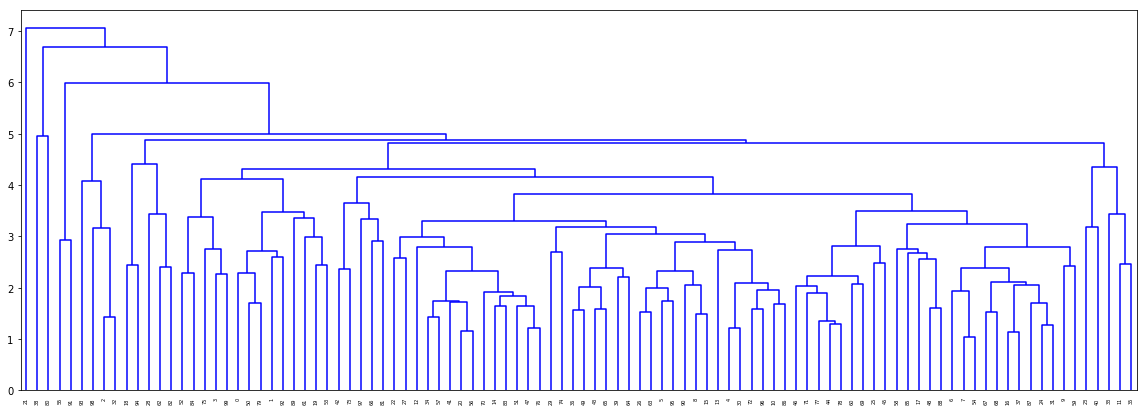

In [37]:
linkage_matrix = linkage(data, 'average')
plt.figure(figsize=(20,7))
dendrogram(linkage_matrix, color_threshold=0)
plt.show()

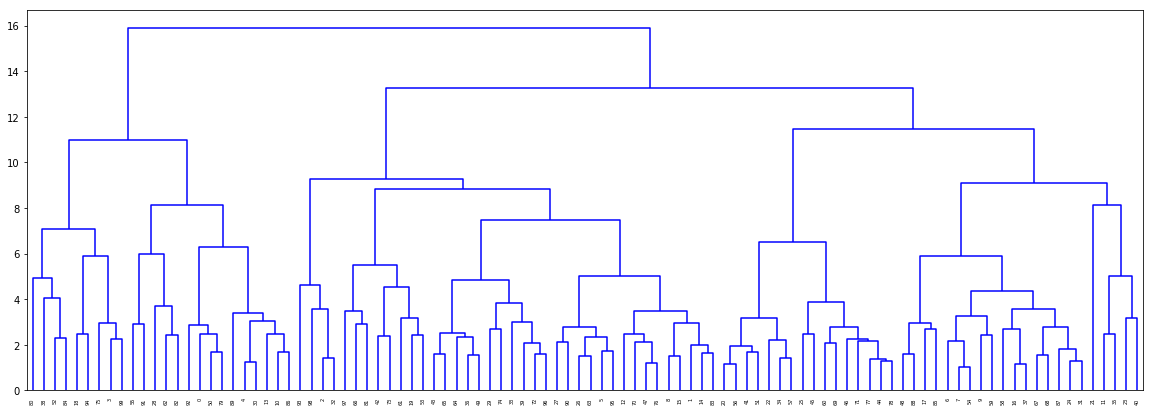

In [35]:
linkage_matrix = linkage(data, 'ward')
plt.figure(figsize=(20,7))
dendrogram(linkage_matrix, color_threshold=0)
plt.show()

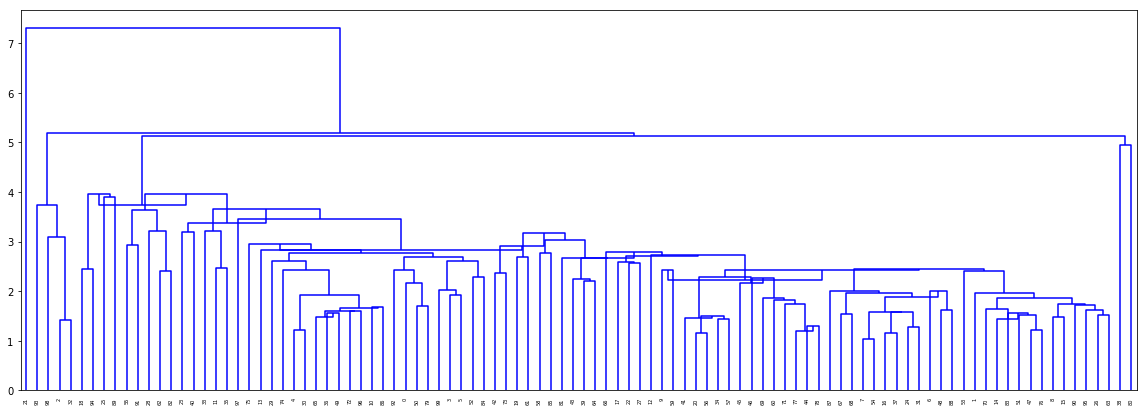

In [45]:
linkage_matrix = linkage(data, 'median')
plt.figure(figsize=(20,7))
dendrogram(linkage_matrix, color_threshold=0)
plt.show()

#### W diagramie wykonanym metodą ward można wyróżnić 3 klastry. W pozostałych ciężko wydzielić niewielką liczbę klastrów. 

# Podsumowanie i wnioski

#### W poprzednim roku zdecydowanie najpopularniejsze były taneczne utwory. 